In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
2.6.2


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['time_id', 'row_id'], inplace=True, axis=1)
investment_id = df.pop("investment_id")
y = df.pop("target")

investment_ids = list(investment_id.unique())
investment_id_lookup_layer = IntegerLookup(oov_token=-1, output_mode='int')
investment_id_lookup_layer.adapt(np.array(investment_ids))
vocab = investment_id_lookup_layer.get_vocabulary(include_special_tokens=True)
vocab_size = investment_id_lookup_layer.vocabulary_size()
print(max(investment_ids))
print(vocab_size)

3773
3580


In [3]:
def preprocess(x, y):
    # TODO
    return x, y

def make_dataset(feature, investment_id, y, batch_size=2048, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(8192, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    return 1 - tf.math.abs(pearson_corr(y_true, y_pred, axis=axis))

In [4]:
# Model
def build_model():
    investment_id_inputs = Input((1, ), name='inv_id_in', dtype=tf.uint16)
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(vocab_size, 128, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(128, activation='swish')(investment_id_x)
    investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    investment_id_x = Dropout(0.2)(investment_id_x)

    feature_x = GaussianNoise(0.01)(features_inputs)
    feature_x = Dense(512, activation='swish')(feature_x)
    feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    feature_x = Dropout(0.2)(feature_x)

    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(512, activation='swish')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='swish')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='swish')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='swish')(x)
    x = Dropout(0.1)(x)
    xOut = Dense(1, name='output')(x)

    model = Model(inputs=[investment_id_inputs, features_inputs], outputs=[xOut])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mse', 'mae'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_id_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           inv_id_in[0][0]                  
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       458240      integer_lookup[0][0]             
__________________________________________________________________________________________________
feature_in (InputLayer)         [(None, 300)]        0                                            
______________________________________________________________________________________________

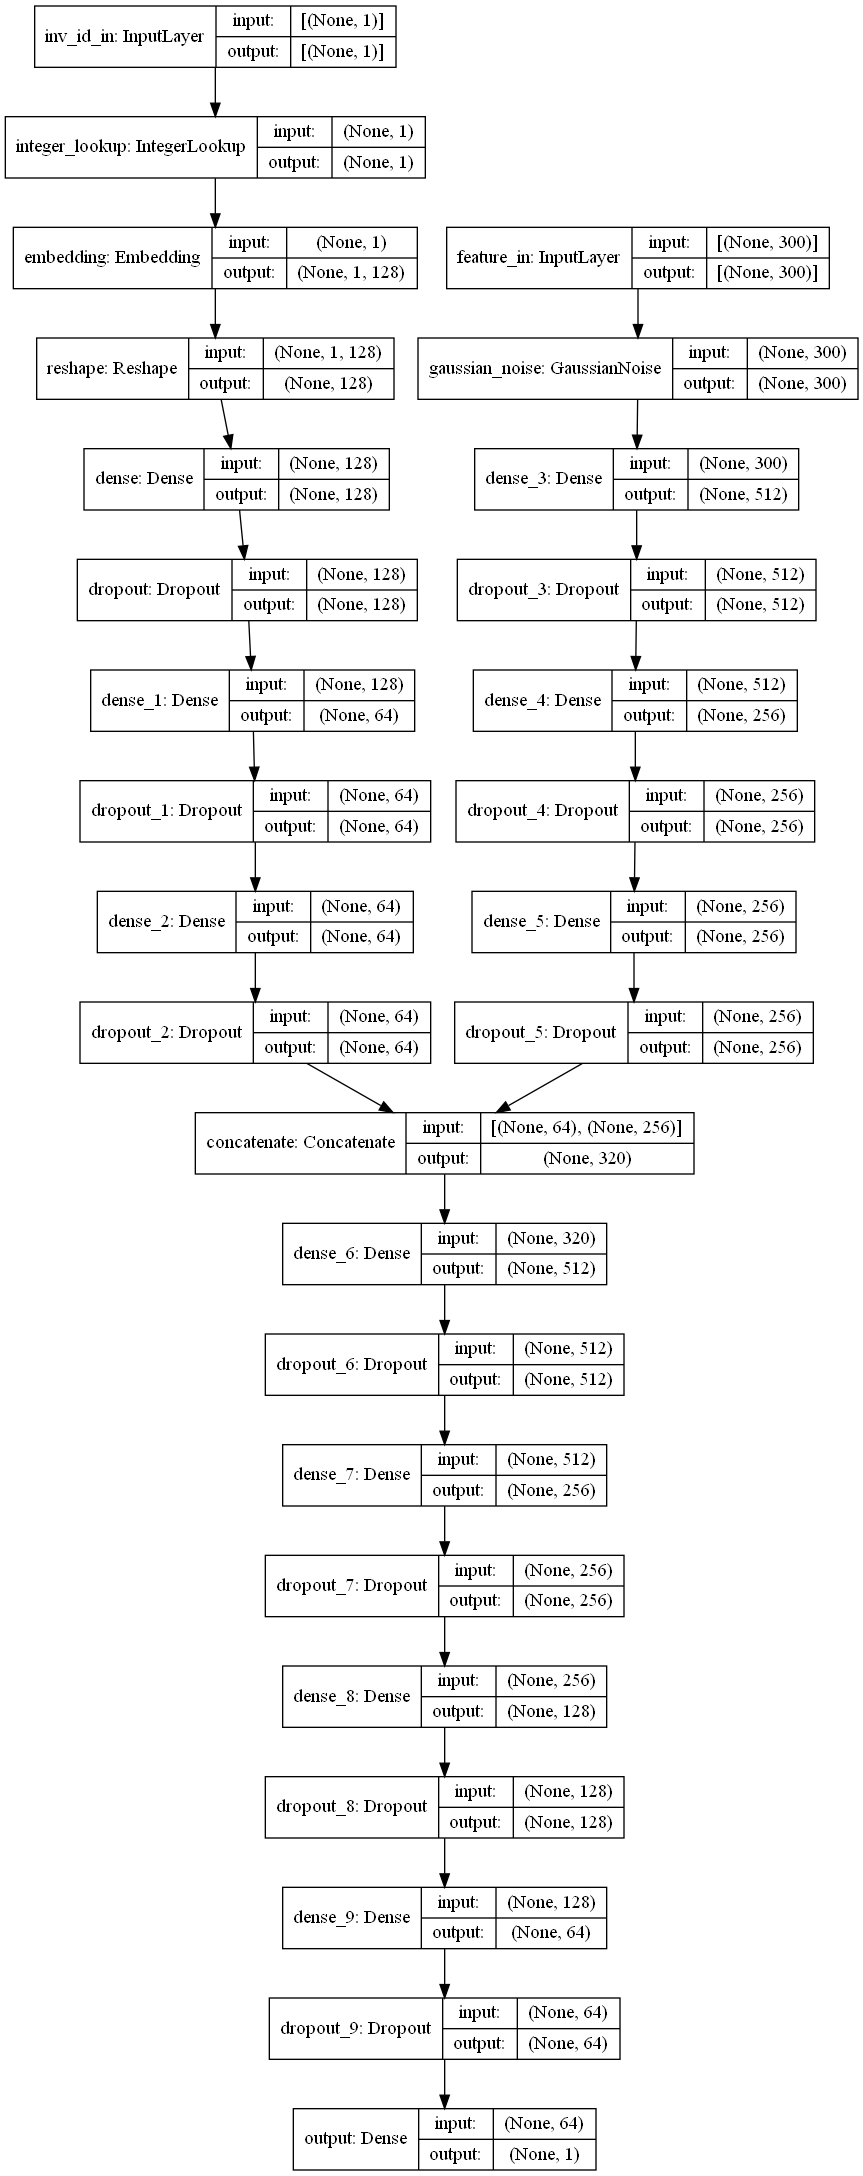

In [5]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
models = []

for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    X_train, X_val = df.iloc[train_indices], df.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True),
                 tf.keras.callbacks.EarlyStopping(patience=10),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)]
    history = model.fit(train_ds, epochs=15, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}"))

    pearson_score = scipy.stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    # pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    # plt.title("MSE")
    # plt.show()
    # pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    # plt.title("MAE")
    # plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/15
1228/1228 [==============================] - 17s 8ms/step - loss: 0.8312 - mse: 0.8312 - mae: 0.6241 - val_loss: 0.8351 - val_mse: 0.8351 - val_mae: 0.6271
INFO:tensorflow:Assets written to: model_0\assets
Epoch 2/15
1228/1228 [==============================] - 12s 9ms/step - loss: 0.8287 - mse: 0.8287 - mae: 0.6235 - val_loss: 0.8329 - val_mse: 0.8329 - val_mae: 0.6266
INFO:tensorflow:Assets written to: model_0\assets
Epoch 3/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8256 - mse: 0.8256 - mae: 0.6225 - val_loss: 0.8313 - val_mse: 0.8313 - val_mae: 0.6262
INFO:tensorflow:Assets written to: model_0\assets
Epoch 4/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8248 - mse: 0.8248 - mae: 0.6223 - val_loss: 0.8330 - val_mse: 0.8329 - val_mae: 0.6269
Epoch 5/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8231 - mse: 0.8230 - mae: 0.6219 - val_loss: 0.8298 - val_mse: 0.8298 - val_mae: 0.6270
INFO:tensorflow:As

Pearson: 0.13141610350473465
Epoch 1/15
1228/1228 [==============================] - 12s 8ms/step - loss: 0.8315 - mse: 0.8315 - mae: 0.6245 - val_loss: 0.8372 - val_mse: 0.8372 - val_mae: 0.6280
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 2/15
1228/1228 [==============================] - 9s 7ms/step - loss: 0.8284 - mse: 0.8284 - mae: 0.6237 - val_loss: 0.8364 - val_mse: 0.8364 - val_mae: 0.6273
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 3/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8255 - mse: 0.8254 - mae: 0.6227 - val_loss: 0.8349 - val_mse: 0.8349 - val_mae: 0.6281
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 4/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8248 - mse: 0.8247 - mae: 0.6226 - val_loss: 0.8337 - val_mse: 0.8337 - val_mae: 0.6276
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 5/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8237 - mse: 0.8237 - mae: 0.6224 - val_loss: 0.8329 - val_mse: 0.8329 - val_mae: 0.6272
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 6/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8224 - mse: 0.8224 - mae: 0.6221 - val_loss: 0.8338 - val_mse: 0.8339 - val_mae: 0.6284
Epoch 7/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8211 - mse: 0.8211 - mae: 0.6217 - val_loss: 0.8319 - val_mse: 0.8319 - val_mae: 0.6282
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 8/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8198 - mse: 0.8197 - mae: 0.6213 - val_loss: 0.8329 - val_mse: 0.8329 - val_mae: 0.6288
Epoch 9/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8187 - mse: 0.8187 - mae: 0.6210 - val_loss: 0.8327 - val_mse: 0.8326 - val_mae: 0.6294
Epoch 10/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8166 - mse: 0.8166 - mae: 0.6204 - val_loss: 0.8325 - val_mse: 0.8325 - val_mae: 0.6284
Epoch 11/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8152 - mse: 0.8152 - mae: 0.6200 - val_loss: 0.8324 - val_mse: 0.8324 - val_mae: 0.6280
Epoch 12/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8132 - mse: 0.8132 - mae: 0.6193 - val_loss: 0.8307 - val_mse: 0.8307 - val_mae: 0.6274
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 13/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8113 - mse: 0.8113 - mae: 0.6188 - val_loss: 0.8306 - val_mse: 0.8306 - val_mae: 0.6281
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 14/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8101 - mse: 0.8101 - mae: 0.6184 - val_loss: 0.8310 - val_mse: 0.8310 - val_mae: 0.6283
Epoch 15/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8081 - mse: 0.8081 - mae: 0.6180 - val_loss: 0.8317 - val_mse: 0.8317 - val_mae: 0.6285


Pearson: 0.12791937864223688
Epoch 1/15
1228/1228 [==============================] - 12s 8ms/step - loss: 0.8316 - mse: 0.8316 - mae: 0.6243 - val_loss: 0.8333 - val_mse: 0.8333 - val_mae: 0.6260
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 2/15
1228/1228 [==============================] - 10s 8ms/step - loss: 0.8287 - mse: 0.8287 - mae: 0.6235 - val_loss: 0.8349 - val_mse: 0.8349 - val_mae: 0.6269
Epoch 3/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8259 - mse: 0.8259 - mae: 0.6228 - val_loss: 0.8316 - val_mse: 0.8316 - val_mae: 0.6269
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 4/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8243 - mse: 0.8243 - mae: 0.6223 - val_loss: 0.8318 - val_mse: 0.8318 - val_mae: 0.6266
Epoch 5/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8230 - mse: 0.8230 - mae: 0.6220 - val_loss: 0.8318 - val_mse: 0.8318 - val_mae: 0.6273
Epoch 6/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8218 - mse: 0.8218 - mae: 0.6217 - val_loss: 0.8322 - val_mse: 0.8322 - val_mae: 0.6268
Epoch 7/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8212 - mse: 0.8212 - mae: 0.6215 - val_loss: 0.8288 - val_mse: 0.8288 - val_mae: 0.6265
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 8/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8200 - mse: 0.8200 - mae: 0.6213 - val_loss: 0.8309 - val_mse: 0.8308 - val_mae: 0.6284
Epoch 9/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8181 - mse: 0.8181 - mae: 0.6208 - val_loss: 0.8298 - val_mse: 0.8298 - val_mae: 0.6279
Epoch 10/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8175 - mse: 0.8175 - mae: 0.6206 - val_loss: 0.8304 - val_mse: 0.8303 - val_mae: 0.6272
Epoch 11/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8159 - mse: 0.8159 - mae: 0.6201 - val_loss: 0.8279 - val_mse: 0.8279 - val_mae: 0.6274
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 12/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8148 - mse: 0.8148 - mae: 0.6198 - val_loss: 0.8301 - val_mse: 0.8300 - val_mae: 0.6286
Epoch 13/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8130 - mse: 0.8130 - mae: 0.6193 - val_loss: 0.8280 - val_mse: 0.8280 - val_mae: 0.6283
Epoch 14/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8112 - mse: 0.8112 - mae: 0.6188 - val_loss: 0.8292 - val_mse: 0.8292 - val_mae: 0.6283
Epoch 15/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8098 - mse: 0.8098 - mae: 0.6185 - val_loss: 0.8294 - val_mse: 0.8294 - val_mae: 0.6289


Pearson: 0.12584664401288173
Epoch 1/15
1228/1228 [==============================] - 12s 8ms/step - loss: 0.8294 - mse: 0.8294 - mae: 0.6238 - val_loss: 0.8445 - val_mse: 0.8445 - val_mae: 0.6295
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 2/15
1228/1228 [==============================] - 9s 7ms/step - loss: 0.8266 - mse: 0.8266 - mae: 0.6229 - val_loss: 0.8467 - val_mse: 0.8467 - val_mae: 0.6301
Epoch 3/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8237 - mse: 0.8237 - mae: 0.6222 - val_loss: 0.8448 - val_mse: 0.8448 - val_mae: 0.6303
Epoch 4/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8222 - mse: 0.8222 - mae: 0.6218 - val_loss: 0.8399 - val_mse: 0.8399 - val_mae: 0.6286
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 5/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8210 - mse: 0.8210 - mae: 0.6215 - val_loss: 0.8428 - val_mse: 0.8428 - val_mae: 0.6297
Epoch 6/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8199 - mse: 0.8199 - mae: 0.6211 - val_loss: 0.8391 - val_mse: 0.8391 - val_mae: 0.6290
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 7/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8186 - mse: 0.8186 - mae: 0.6208 - val_loss: 0.8387 - val_mse: 0.8387 - val_mae: 0.6292
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 8/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8173 - mse: 0.8173 - mae: 0.6204 - val_loss: 0.8369 - val_mse: 0.8369 - val_mae: 0.6287
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 9/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8160 - mse: 0.8160 - mae: 0.6200 - val_loss: 0.8377 - val_mse: 0.8376 - val_mae: 0.6292
Epoch 10/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8146 - mse: 0.8146 - mae: 0.6197 - val_loss: 0.8366 - val_mse: 0.8366 - val_mae: 0.6286
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 11/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8129 - mse: 0.8129 - mae: 0.6192 - val_loss: 0.8359 - val_mse: 0.8359 - val_mae: 0.6294
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 12/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8116 - mse: 0.8116 - mae: 0.6190 - val_loss: 0.8358 - val_mse: 0.8358 - val_mae: 0.6285
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 13/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8100 - mse: 0.8100 - mae: 0.6186 - val_loss: 0.8356 - val_mse: 0.8356 - val_mae: 0.6300
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 14/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8079 - mse: 0.8079 - mae: 0.6179 - val_loss: 0.8357 - val_mse: 0.8357 - val_mae: 0.6294
Epoch 15/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8064 - mse: 0.8064 - mae: 0.6175 - val_loss: 0.8366 - val_mse: 0.8366 - val_mae: 0.6309


Pearson: 0.13532369068551778
Epoch 1/15
1228/1228 [==============================] - 12s 8ms/step - loss: 0.8293 - mse: 0.8292 - mae: 0.6237 - val_loss: 0.8434 - val_mse: 0.8434 - val_mae: 0.6281
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 2/15
1228/1228 [==============================] - 10s 8ms/step - loss: 0.8267 - mse: 0.8267 - mae: 0.6231 - val_loss: 0.8414 - val_mse: 0.8414 - val_mae: 0.6298
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 3/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8242 - mse: 0.8242 - mae: 0.6223 - val_loss: 0.8433 - val_mse: 0.8433 - val_mae: 0.6291
Epoch 4/15
1228/1228 [==============================] - 9s 7ms/step - loss: 0.8227 - mse: 0.8227 - mae: 0.6219 - val_loss: 0.8379 - val_mse: 0.8379 - val_mae: 0.6281
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 5/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8222 - mse: 0.8222 - mae: 0.6218 - val_loss: 0.8384 - val_mse: 0.8384 - val_mae: 0.6294
Epoch 6/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8210 - mse: 0.8210 - mae: 0.6215 - val_loss: 0.8381 - val_mse: 0.8381 - val_mae: 0.6303
Epoch 7/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8200 - mse: 0.8200 - mae: 0.6212 - val_loss: 0.8376 - val_mse: 0.8375 - val_mae: 0.6284
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 8/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8193 - mse: 0.8192 - mae: 0.6211 - val_loss: 0.8363 - val_mse: 0.8363 - val_mae: 0.6287
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 9/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8179 - mse: 0.8179 - mae: 0.6208 - val_loss: 0.8358 - val_mse: 0.8358 - val_mae: 0.6283
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 10/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8163 - mse: 0.8163 - mae: 0.6202 - val_loss: 0.8353 - val_mse: 0.8353 - val_mae: 0.6300
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 11/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8146 - mse: 0.8146 - mae: 0.6198 - val_loss: 0.8366 - val_mse: 0.8366 - val_mae: 0.6294
Epoch 12/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8131 - mse: 0.8130 - mae: 0.6194 - val_loss: 0.8365 - val_mse: 0.8365 - val_mae: 0.6304
Epoch 13/15
1228/1228 [==============================] - 8s 6ms/step - loss: 0.8111 - mse: 0.8111 - mae: 0.6188 - val_loss: 0.8346 - val_mse: 0.8346 - val_mae: 0.6290
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 14/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8092 - mse: 0.8092 - mae: 0.6182 - val_loss: 0.8356 - val_mse: 0.8356 - val_mae: 0.6307
Epoch 15/15
1228/1228 [==============================] - 8s 7ms/step - loss: 0.8078 - mse: 0.8078 - mae: 0.6178 - val_loss: 0.8356 - val_mse: 0.8356 - val_mae: 0.6295


Pearson: 0.1333821840102213


In [7]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=2048):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)  # ensemble


models = [load_model(f'model_{index}') for index in range(kfold.n_splits)]
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test[test["investment_id"] < 100][:100])
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

   row_id    target
59    1_1  0.059540
60    1_2 -0.007275
61    1_6  0.013092
62    1_7 -0.012108
63    1_8  0.050934
64    1_9 -0.032745
65   1_10  0.056030
66   1_12  0.017273
67   1_13 -0.085388
68   1_14  0.019409
69   1_16  0.005058
70   1_17 -0.051056
71   1_19  0.036835
72   1_20  0.034515
73   1_22 -0.090820
74   1_24 -0.015556
75   1_29 -0.013260
76   1_30  0.066528
77   1_31 -0.068542
78   1_32  0.022202
79   1_33  0.046112
80   1_34  0.010635
81   1_35 -0.008781
82   1_36 -0.013992
83   1_40 -0.155640
84   1_41  0.028915
85   1_42 -0.032623
86   1_44  0.031082
87   1_46  0.017075
88   1_47  0.073975
89   1_48 -0.173584
90   1_50  0.076477
91   1_51 -0.024857
92   1_54  0.030273
93   1_55  0.018280
94   1_58 -0.015495
95   1_59  0.003290
96   1_61  0.028091
97   1_62  0.067383
98   1_63  0.042358
99   1_66  0.019760
Pearson: 0.17746031406221846


In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')